# Alzheimers Prediction - Refactored Approach

_Predicting Cognitively Normal (CN), Mild Cognitive Impairment (MCI), or Alzheimers (AD)_

## Variable Descriptions
* `directory.id`	Id assigned to imaging directories. Not from LONi data
* `Subject (PTID)`	Participant ID
* `RID`	Participant roster ID
* `Image.Data.ID`	MRI ID
* `Modality`	Image type
* `Visit`	1=screening scan
* `Acq.Date`	MRI date
* `DX.bl`	Diagnosis at baseline
* `EXAMDATE`	Examination Date
* `AGE`	    Age at baseline
* `PTGENDER`	Sex
* `PTEDUCAT`	Years of Education
* `PTETHCAT`	Ethnicity
* `PTRACCAT`	Race
* `APOE4`	APOE4 genotype
* `MMSE`	MMSE score on cognitive test
* `imputed_genotype`	Challenge specific designation, TRUE=has imputed genotypes
* `APOE Genotype`	APOE allele 1 and allele 2 genotypes

### Target
* `Dx Codes for Submission`	The LMCI in the ADNI data is equivalent to MCI in test. This column just converts LMCI->MCI

In [2]:
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

## Exploration & Pre-processing

In [3]:
df = pd.read_csv('data/challenges/train/ADNI_Training_Q3_APOE_CollectionADNI1Complete 1Yr 1.5T_July22.2014.csv')

df.head()

,directory.id,Subject,RID,Image.Data.ID,Modality,Visit,Acq.Date,DX.bl,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,4702245ea294ce5d4e9b8a87027dfdf4,011_S_0003,3,32237,MRI,1,9/1/05,AD,9/12/05,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD
1,2e89e352af743597b2368c412e0f6de2,022_S_0004,4,64631,MRI,1,9/22/05,LMCI,11/8/05,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3",MCI
2,90419199306997753de8042f1fd55e38,011_S_0005,5,32246,MRI,1,9/2/05,CN,9/7/05,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3",CN
3,d8d175ffff1e2053e6a18c5df494ccdf,100_S_0006,6,33025,MRI,1,11/15/05,LMCI,11/29/05,80.4,Female,13,Not Hisp/Latino,White,0,25,True,"3,3",MCI
4,986e75b2e604cd44b38feb2188476fb2,011_S_0010,10,32270,MRI,1,11/7/05,AD,11/10/05,73.9,Female,12,Not Hisp/Latino,White,1,24,True,"3,4",AD


In [4]:
# Small dataset
df.shape

(628, 19)

In [5]:
# Class balance
df['Dx Codes for Submission'].value_counts()

MCI    305
CN     190
AD     133
Name: Dx Codes for Submission, dtype: int64

In [6]:
X = df[['AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'APOE4', 'MMSE', 'APOE Genotype']]
y_dx = df['Dx Codes for Submission']

X.head()

,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,APOE Genotype
0,81.3,Male,18,Not Hisp/Latino,White,1,20,"3,4"
1,67.5,Male,10,Hisp/Latino,White,0,27,"3,3"
2,73.7,Male,16,Not Hisp/Latino,White,0,29,"3,3"
3,80.4,Female,13,Not Hisp/Latino,White,0,25,"3,3"
4,73.9,Female,12,Not Hisp/Latino,White,1,24,"3,4"


Let's convert this to a binary classification problem:

(MCI, CN) => Not AD

In [7]:
mapping = {'CN': 0, 'MCI': 0, 'AD': 1}
y = pd.Series([mapping[label] for label in y_dx])

y

0      1
1      0
2      0
3      0
4      1
      ..
623    0
624    0
625    0
626    0
627    0
Length: 628, dtype: int64

In [8]:
X['APOE Genotype'].value_counts()

3,3    276
3,4    221
4,4     71
2,3     45
2,4     13
2,2      2
Name: APOE Genotype, dtype: int64

In [9]:
# No missing values
X.isnull().sum()

AGE              0
PTGENDER         0
PTEDUCAT         0
PTETHCAT         0
PTRACCAT         0
APOE4            0
MMSE             0
APOE Genotype    0
dtype: int64

In [10]:
X['PTGENDER'].value_counts()

Male      364
Female    264
Name: PTGENDER, dtype: int64

Categorical variable distributions:


Distribution of PTRACCAT
White    584
Black     31
Asian     13
Name: PTRACCAT, dtype: int64


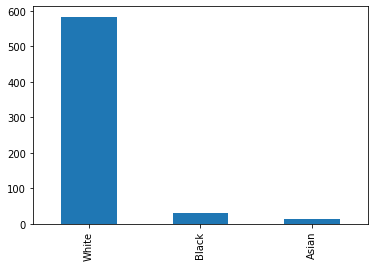


Distribution of PTETHCAT
Not Hisp/Latino    617
Hisp/Latino          8
Unknown              3
Name: PTETHCAT, dtype: int64


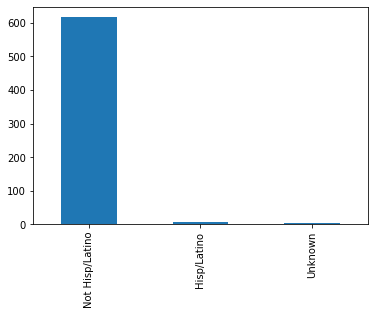


Distribution of APOE Genotype
3,3    276
3,4    221
4,4     71
2,3     45
2,4     13
2,2      2
Name: APOE Genotype, dtype: int64


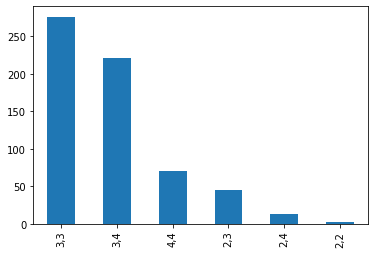


Distribution of PTGENDER
Male      364
Female    264
Name: PTGENDER, dtype: int64


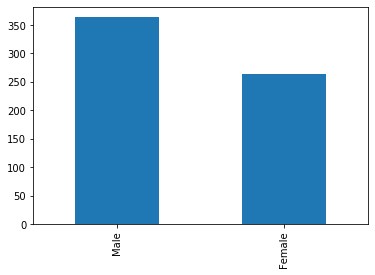


Distribution of APOE4
0    323
1    234
2     71
Name: APOE4, dtype: int64


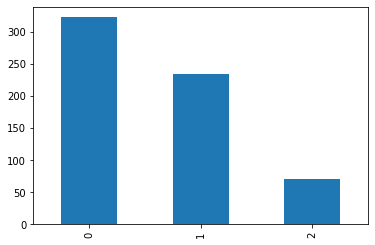

In [11]:
numerical_vars = ['AGE', 'PTEDUCAT', 'MMSE']
cat_vars = list(set(X.columns) - set(numerical_vars))

def eval_cat_vars(X, variables):
    print('Categorical variable distributions:\n')

    for var in variables:
        print('\nDistribution of', var)

        dist = X[var].value_counts()
        print(dist)
        dist.plot(kind='bar')
        plt.show()
        
eval_cat_vars(X, cat_vars)

Numerical Var Distributions:



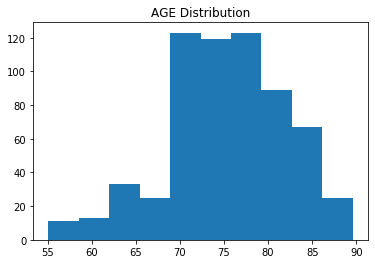

count    628.000000
mean      75.169586
std        6.687429
min       55.100000
25%       71.200000
50%       75.450000
75%       80.000000
max       89.600000
Name: AGE, dtype: float64


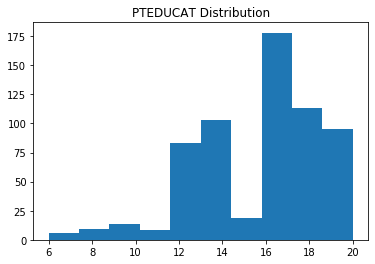

count    628.000000
mean      15.616242
std        2.977993
min        6.000000
25%       13.000000
50%       16.000000
75%       18.000000
max       20.000000
Name: PTEDUCAT, dtype: float64


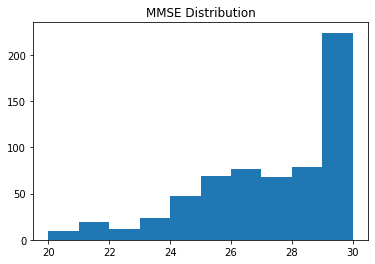

count    628.000000
mean      26.920382
std        2.562152
min       20.000000
25%       25.000000
50%       27.000000
75%       29.000000
max       30.000000
Name: MMSE, dtype: float64


In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

def eval_num_vars(X, variables):
    print('Numerical Var Distributions:\n')

    for var in variables:
        plt.hist(X[var], bins=10)
        plt.title(var + ' Distribution')
        plt.show()

        # descriptive stats
        print(X[var].describe())
        
eval_num_vars(X, numerical_vars)

## Pre-processing

One-hot encode

In [13]:
X.head()

,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,APOE Genotype
0,81.3,Male,18,Not Hisp/Latino,White,1,20,"3,4"
1,67.5,Male,10,Hisp/Latino,White,0,27,"3,3"
2,73.7,Male,16,Not Hisp/Latino,White,0,29,"3,3"
3,80.4,Female,13,Not Hisp/Latino,White,0,25,"3,3"
4,73.9,Female,12,Not Hisp/Latino,White,1,24,"3,4"


In [14]:
for var in cat_vars:
    print('Converting', var, 'to 1-hot encoding')
    
    #get 1-hot and replace original column with the >= 2 categories as columns
    one_hot_df = pd.get_dummies(X[var])
    X = pd.concat([X, one_hot_df], axis=1)
    X = X.drop(var, axis=1)
    
X.head(4)

Converting PTRACCAT to 1-hot encoding
Converting PTETHCAT to 1-hot encoding
Converting APOE Genotype to 1-hot encoding
Converting PTGENDER to 1-hot encoding
Converting APOE4 to 1-hot encoding


,AGE,PTEDUCAT,MMSE,Asian,Black,White,Hisp/Latino,Not Hisp/Latino,Unknown,"2,2","2,3","2,4","3,3","3,4","4,4",Female,Male,0,1,2
0,81.3,18,20,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0
1,67.5,10,27,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0
2,73.7,16,29,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0
3,80.4,13,25,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0


Normalize numerical values [0, 1]

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit and transform the data using the scaler
X[['AGE', 'PTEDUCAT', 'MMSE']] = scaler.fit_transform(X[['AGE', 'PTEDUCAT', 'MMSE']])
X.head()

,AGE,PTEDUCAT,MMSE,Asian,Black,White,Hisp/Latino,Not Hisp/Latino,Unknown,"2,2","2,3","2,4","3,3","3,4","4,4",Female,Male,0,1,2
0,0.759420,0.857143,0.0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0
1,0.359420,0.285714,0.7,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0
2,0.539130,0.714286,0.9,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0
3,0.733333,0.500000,0.5,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0
4,0.544928,0.428571,0.4,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0


## Train & Validate

In [16]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

Train set: (502, 20)
Test set: (126, 20)


In [17]:
# Careful of a little class imbalance
print(y_train.value_counts())
print(y_test.value_counts())

0    392
1    110
dtype: int64
0    103
1     23
dtype: int64


First, compare a few models with their default hyperparameters.

In [18]:
y_train

332    0
6      0
104    0
114    0
482    0
      ..
71     0
106    0
270    0
435    0
102    1
Length: 502, dtype: int64

**Note:** There was a prior subsample for a validation set that was used here to compare models. 

Variables: `X_valid`, `y_valid`

In [21]:
# from sklearn.linear_model import LogisticRegression

# lr = LogisticRegression()

# # Fit the model on the training data
# lr.fit(X_train, y_train)

# # Make predictions on the validation data
# y_pred = lr.predict(X_valid)

In [22]:
# from sklearn.metrics import accuracy_score

# lr_accuracy = accuracy_score(y_pred, y_valid)
# print(f"Logistic Regression Validation Accuracy: {lr_accuracy:.2%}")

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = rf.predict(X_valid)

from sklearn.metrics import accuracy_score

rf_accuracy = accuracy_score(y_pred, y_valid)
print(f"Random Forest Validation Accuracy: {rf_accuracy:.2%}")

Random Forest Validation Accuracy: 68.25%


In [24]:
# Create a GradientBoostingClassifier object
gb = GradientBoostingClassifier(random_state=42)

# Fit the model to the training data
gb.fit(X_train, y_train)

# Predict the classes of the validation set
y_pred = gb.predict(X_valid)

gb_accuracy = accuracy_score(y_pred, y_valid)
print(f"Boosting Validation Accuracy: {gb_accuracy:.2%}")

Boosting Validation Accuracy: 74.60%


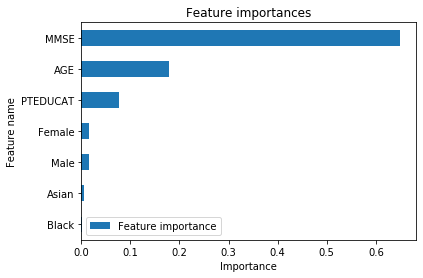

In [25]:
feat_importances = gb.feature_importances_[:7]
feat_names = X_train.columns[:7]
feat_importances_df = pd.DataFrame({'Feature name':feat_names, 'Feature importance':feat_importances})
feat_importances_df.sort_values(by='Feature importance', inplace=True)
feat_importances_df.plot(kind='barh', x='Feature name', y='Feature importance')
plt.title('Feature importances')
plt.xlabel('Importance')
plt.ylabel('Feature name')
plt.show()

### Feature Importance
Unsurprisingly, cognitive test scores (`MMSE`) and age (`AGE`) are major contributors to the model. Interestingly, gender also appears to be somewhat predictive. 

One might wonder why its not more predictive given that roughly [2/3 of those living with Alzheimer's in the US are women.](https://www.health.harvard.edu/blog/why-are-women-more-likely-to-develop-alzheimers-disease-202201202672) Theories suggest the primary reason for this is that women tend to live longer. Thus, `AGE` being our second most important feature already captures that information.

### Some hyperparemeter tuning

Dataset may be too small for hyperparameter tuning.

In [1]:
# learning_rates = [0.01, 0.05, .1, .2]
# n_estimators = [50, 100, 300]
# min_samples_splits = [2, 3, 4]
# max_depths = [2,3,4,5]
# max_features = ['auto', 'sqrt', 'log2']

In [2]:
# best_accuracy = float('-inf')
# best_hparams = {
#     'learning_rate': None,
#     'n_estimators': None,
#     'min_samples_split': None,
#     'max_depth': None,
#     'max_features': None
# }

# for learning_rate in learning_rates:
#     for n in n_estimators:
#         for min_samples_split in min_samples_splits:
#             for max_depth in max_depths:
#                 for max_feature in max_features:
#                     #print(learning_rate, n, min_samples_split, max_depth, max_feature)
                    
#                     curr_gb = GradientBoostingClassifier(
#                         learning_rate=learning_rate,
#                         n_estimators=n,
#                         min_samples_split=min_samples_split,
#                         max_depth=max_depth,
#                         max_features=max_feature,
#                         random_state=42
#                     )

#                     # Fit the model to the training data
#                     curr_gb.fit(X_train, y_train)

#                     # Predict the classes of the validation set
#                     y_pred = curr_gb.predict(X_valid)

#                     curr_gb_accuracy = accuracy_score(y_pred, y_valid)
                    
#                     if curr_gb_accuracy > best_accuracy:
#                         best_accuracy = curr_gb_accuracy
#                         best_hparams = {
#                             'learning_rate': learning_rate,
#                             'n_estimators': n,
#                             'min_samples_split': min_samples_split,
#                             'max_depth': max_depth,
#                             'max_features': max_feature
#                         }
#                         print(f'New best accuracy: {best_accuracy:.2%} with params: {best_hparams}\n')

Can also use `GridSearchCV`

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

# Train on best hparams
gb = GradientBoostingClassifier(n_estimators=300, random_state=42)

# Fit the model to the training data
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Evaluate on the test set

In [25]:
# Predict on test set
y_pred = gb.predict(X_test)

# Evaluate predictions
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_acc:.2%}")

Test accuracy: 90.48%


/Users/grantgasser/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


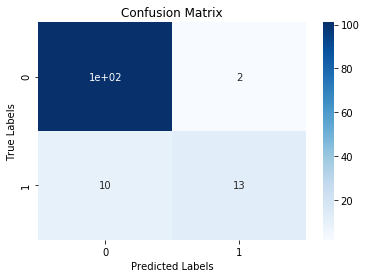

In [26]:
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

fix, ax = plt.subplots(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred)

# plot heatmap of confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", ax=ax)
ax.set_ylim(2, 0)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title('Confusion Matrix')
plt.show()

In [27]:
cm

array([[101,   2],
       [ 10,  13]])

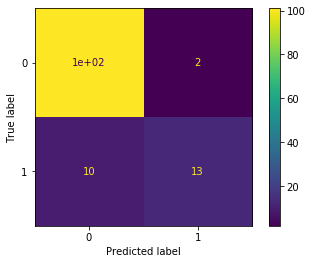

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb.classes_)
disp.plot()
plt.show()

In [29]:
print(f'Precision: {precision_score(y_test, y_pred):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'F1: {f1_score(y_test, y_pred):.2f}')
print(f'AUC: {roc_auc_score(y_test, y_pred):.2f}')

Precision: 0.87
Recall: 0.57
F1: 0.68
AUC: 0.77


Appears to be an issue with False Negatives (10) more so than false positives. As a general rule in medicine, it is likely better to have a false positive than a false negative. 

A positive yields more investigation and caution. A negative yields inaction, which is not good. _Let's lower the threshold to make the model a bit more aggressive._

**Chose 0.1 with a bit of trial and error, which is somewhat cheating. Would need to do so with a validation set**

In [30]:
thresh = 0.1

probs = gb.predict_proba(X_test)[:,1]
y_pred = (probs > thresh).astype(int)

In [31]:
print(f'Precision: {precision_score(y_test, y_pred):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')
print(f'F1: {f1_score(y_test, y_pred):.2f}')
print(f'AUC: {roc_auc_score(y_test, y_pred):.2f}')

Precision: 0.67
Recall: 0.87
F1: 0.75
AUC: 0.89


In [32]:
# Now we're down to only 3 False Negatives
cm = confusion_matrix(y_test, y_pred)
cm

array([[93, 10],
       [ 3, 20]])

In [33]:
# how does accuracy fare given our new threshold?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2%}')

Accuracy: 89.68%


## Analyze Misclassifications

In [34]:
y_missed = y_pred != y_test
X_missed = X_test[y_missed]

# in case needed
missed_idx = X_missed.index

y_test_missed = y_test[y_missed]
y_pred_missed = y_pred[y_missed]
y_probs_missed = probs[y_missed]

In [35]:
y_test_missed = y_test_missed.reset_index(drop=True).rename('y_true')
y_probs_missed = pd.Series(y_probs_missed).reset_index(drop=True).rename('y_probs')
y_pred_missed = pd.Series(y_pred_missed).reset_index(drop=True).rename('y_pred')

y_concat = pd.concat([y_test_missed, y_probs_missed, y_pred_missed], axis=1)
X_missed = pd.concat([X_missed.reset_index(drop=True), y_concat], axis=1)

X_missed

,AGE,PTEDUCAT,MMSE,Asian,Black,White,Hisp/Latino,Not Hisp/Latino,Unknown,"2,2",...,"3,4","4,4",Female,Male,0,1,2,y_true,y_probs,y_pred
0,0.991304,0.500000,0.6,0,0,1,0,1,0,0,...,0,0,0,1,1,0,0,0,0.950242,1
1,0.553623,1.000000,0.6,0,0,1,0,1,0,0,...,1,0,0,1,0,1,0,0,0.155638,1
2,0.811594,0.785714,0.3,0,0,1,0,1,0,0,...,0,1,0,1,0,0,1,0,0.999604,1
3,0.710145,1.000000,0.5,0,0,1,0,1,0,0,...,1,0,0,1,0,1,0,1,0.079563,0
4,0.617391,0.714286,0.4,1,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0.172003,1
5,0.562319,0.928571,0.6,0,0,1,0,1,0,0,...,0,0,0,1,1,0,0,1,0.055878,0
6,1.000000,0.714286,1.0,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0.269735,1
7,0.710145,0.714286,0.6,0,0,1,0,1,0,0,...,1,0,0,1,0,1,0,0,0.375022,1
8,0.428986,0.714286,0.5,0,0,1,0,1,0,0,...,0,0,0,1,1,0,0,0,0.129599,1
9,0.652174,0.714286,0.6,0,0,1,0,1,0,0,...,0,0,0,1,1,0,0,0,0.102379,1


In [36]:
fps = X_missed[(X_missed['y_true'] == 0) & (X_missed['y_pred'] == 1)]
fns = X_missed[(X_missed['y_true'] == 1) & (X_missed['y_pred'] == 0)]

**False Positives**

In [37]:
# Analyze distribution of numerical values of FPs
fps[numerical_vars].describe()[:2]

,AGE,PTEDUCAT,MMSE
count,10.000000,10.000000,10.00
mean,0.722029,0.678571,0.55


In [38]:
X_train[numerical_vars].describe()[:2]

,AGE,PTEDUCAT,MMSE
count,502.000000,502.000000,502.00000
mean,0.582938,0.688532,0.67988


It appears our false positives are on examples where `AGE` is higher and `MMSE` is lower than the means from the training data, which seem to be reasonable mistakes given that high age and low MMSE are correlated with AD.

**False Negatives**

In [39]:
fns

,AGE,PTEDUCAT,MMSE,Asian,Black,White,Hisp/Latino,Not Hisp/Latino,Unknown,"2,2",...,"3,4","4,4",Female,Male,0,1,2,y_true,y_probs,y_pred
3,0.710145,1.000000,0.5,0,0,1,0,1,0,0,...,1,0,0,1,0,1,0,1,0.079563,0
5,0.562319,0.928571,0.6,0,0,1,0,1,0,0,...,0,0,0,1,1,0,0,1,0.055878,0
11,0.594203,0.428571,0.6,0,0,1,0,1,0,0,...,0,0,0,1,1,0,0,1,0.067277,0


Predicting a new patient:

In [56]:
new_sample = new_sample = [61, 17, 30, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

new_df = pd.DataFrame([new_sample], columns=X_train.columns)
new_df

,AGE,PTEDUCAT,MMSE,Asian,Black,White,Hisp/Latino,Not Hisp/Latino,Unknown,"2,2","2,3","2,4","3,3","3,4","4,4",Female,Male,0,1,2
0,61,17,30,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [57]:
new_df[['AGE', 'PTEDUCAT', 'MMSE']] = scaler.transform(new_df[['AGE', 'PTEDUCAT', 'MMSE']])
new_df

,AGE,PTEDUCAT,MMSE,Asian,Black,White,Hisp/Latino,Not Hisp/Latino,Unknown,"2,2","2,3","2,4","3,3","3,4","4,4",Female,Male,0,1,2
0,0.171014,0.785714,1.0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [59]:
gb.predict_proba(new_df)

array([[0.996807, 0.003193]])